In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [310]:
def ImportAndClean(file:str,year:int):
    try:
        if 'NREL' in file:
            #Read in weather file: converting time columns to DateTime, fixing timezone and angle, and selecting used columns
            df = pd.read_csv(file,header=2,usecols=[0,1,2,3,4,13,20,21])
            df['Date'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
            df = df.set_index('Date')
            df.index = df.index+pd.Timedelta(hours=-7)
            df['Solar Zenith Angle'] *= np.pi/180
            df = df.drop(columns=['Year','Month','Day','Hour','Minute'])
            df.index.names = ['Date']
            return df
        elif 'environment' in file:
            #Read in environment file: converting time columns to DateTime and selecting used columns
            df = pd.read_csv(file,index_col=[0],usecols=[0,1,9])
            df = df.set_index(pd.to_datetime(df.index))
            df = df.rename(columns={df.columns[0]: "Ambient Temperature",df.columns[1]: "Wind Sensor"})
            df['Ambient Temperature'] += 273
            df.dropna(inplace=True)
            df.index.names = ['Date']
            return df[df.index.year == year]
        elif 'power' in file:
            #Read in power file: converting time columns to DateTime, selecting power column, and adding energy column
            df = pd.read_csv(file,index_col=0,usecols=[0,14])
            df = df.set_index(pd.to_datetime(df.index))
            df = df.rename(columns={df.columns[0]: "Power"})
            #Energy ~ Power*Time
            df['Energy'] = df['Power']/12
            df = df[['Energy']].dropna()
            df.index.names = ['Date']
            return df[df.index.year == year]
            
    except Exception as e:
        print(f'Error: {e}')

In [311]:
Weather = ImportAndClean("../NREL_Weather/1000190_40.38_-104.55_2022.csv",2022)
Energy = ImportAndClean("../Data_9068/9068_ac_power_data.csv",2022)
Environment = ImportAndClean("../Data_9068/9068_environment_data.csv",2022)
SolarData = pd.merge(pd.merge(Weather,Environment,left_index=True,right_index=True,how="inner"),Energy,left_index=True,right_index=True,how="inner")

In [312]:
SolarData['Day'] = SolarData.index.day_of_year*np.pi/365

In [320]:
SolarData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103530 entries, 2022-01-01 00:00:00 to 2022-12-31 16:55:00
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Cloud Type           103530 non-null  int64  
 1   Relative Humidity    103530 non-null  float64
 2   Solar Zenith Angle   103530 non-null  float64
 3   Ambient Temperature  103530 non-null  float64
 4   Wind Sensor          103530 non-null  float64
 5   Energy               103530 non-null  float64
 6   Day                  103530 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 6.3 MB


In [ ]:
SolarDataPos = SolarData[SolarData['Energy']>0]

,Cloud Type,Relative Humidity,Solar Zenith Angle,Ambient Temperature,Wind Sensor,Energy,Day
Date,,,,,,,
2022-01-01 10:35:00,6,59.83,1.159771,258.1,1.3,0.416667,0.008607
2022-01-01 10:40:00,6,59.36,1.153837,257.9,1.3,0.083333,0.008607
2022-01-01 11:30:00,7,56.14,1.112473,258.4,0.0,0.833333,0.008607
2022-01-01 11:35:00,8,57.75,1.110378,258.7,0.0,1.333333,0.008607
2022-01-01 11:40:00,8,57.30,1.108459,259.1,0.4,1.500000,0.008607
...,...,...,...,...,...,...,...
2022-12-31 16:00:00,0,68.85,1.467996,274.8,1.3,9.916667,3.141593
2022-12-31 16:05:00,0,68.85,1.481086,274.6,1.2,8.333333,3.141593
2022-12-31 16:10:00,7,68.85,1.494176,274.5,1.1,4.083333,3.141593


In [378]:
agg_dict = {col: 'mean' for col in SolarDataPos.columns}
agg_dict['Energy'] = 'sum'
SolarDaily = SolarDataPos.resample('d').agg(agg_dict)

<function matplotlib.pyplot.show(close=None, block=None)>

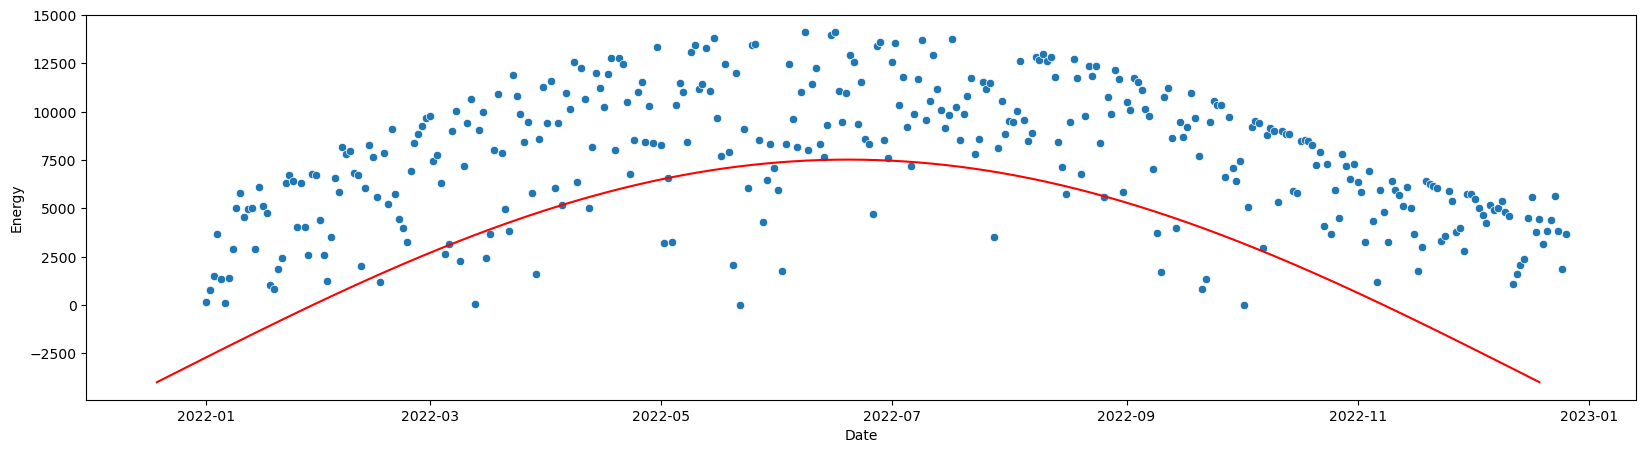

In [380]:
plt.figure(figsize=(20,5))
sns.scatterplot(SolarDaily[:360],x=SolarDaily.index[:360],y=SolarDaily['Energy'].iloc[0:360])
xs = np.linspace(0,365,1000)
ys = np.sin(xs*3.1415/365)
plt.plot(xs+365*52,288*40*ys-4000,'r')
plt.show

In [606]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits = 10,test_size=288)

model_0 = LinearRegression(n_jobs=-1)

X0 = SolarData[['Solar Zenith Angle']]
y0 = SolarData['Energy']

rmse_scores0 = cross_val_score(model_0, X0, y0, cv=tscv, scoring='neg_root_mean_squared_error')

print("RMSE scores:", -rmse_scores0)
print("Average RMSE:", -rmse_scores0.mean())

RMSE scores: [19.29603886 19.82465653 19.58941531 20.84079994 17.98604803 20.26873541
 23.12668613 20.91909069 19.67898216 18.51917539]
Average RMSE: 20.004962843687565


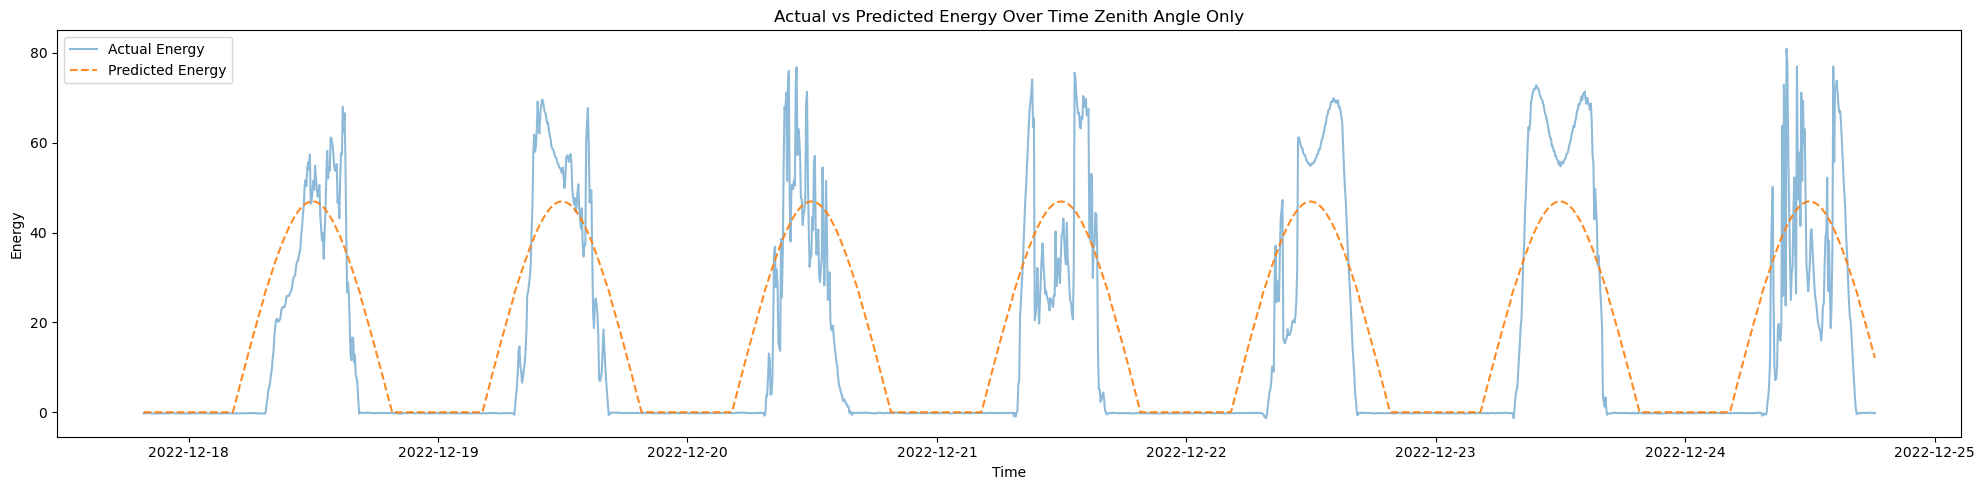

In [607]:
model_0.fit(X0,y0)
y0_pred = model_0.predict(X0)
y0_pred = np.clip(y0_pred,0,80)

plt.figure(figsize=(20, 5))
plt.plot(SolarData.index[-4000:-2000], y0[-4000:-2000], label='Actual Energy', alpha=0.5)
plt.plot(SolarData.index[-4000:-2000], y0_pred[-4000:-2000], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Zenith Angle Only")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [605]:
tscv = TimeSeriesSplit(n_splits = 5)

def sng_cos(x):
    return np.sign(np.cos(x))

model_1 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('sin',FunctionTransformer(np.sin),['Day']),('cos',FunctionTransformer(sng_sin),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('scaling', StandardScaler()),
    ('regression', LinearRegression(n_jobs=-1))
])
X1 = SolarData[['Solar Zenith Angle','Day']]
y1 = SolarData['Energy']

rmse_scores1 = cross_val_score(model_1, X1, y1, cv=tscv, scoring='neg_root_mean_squared_error')

print("RMSE scores:", -rmse_scores1)
print("Average RMSE:", -rmse_scores1.mean())

RMSE scores: [29.92542877 31.51234544 29.86445391 24.44439199 16.22447224]
Average RMSE: 26.394218469886578


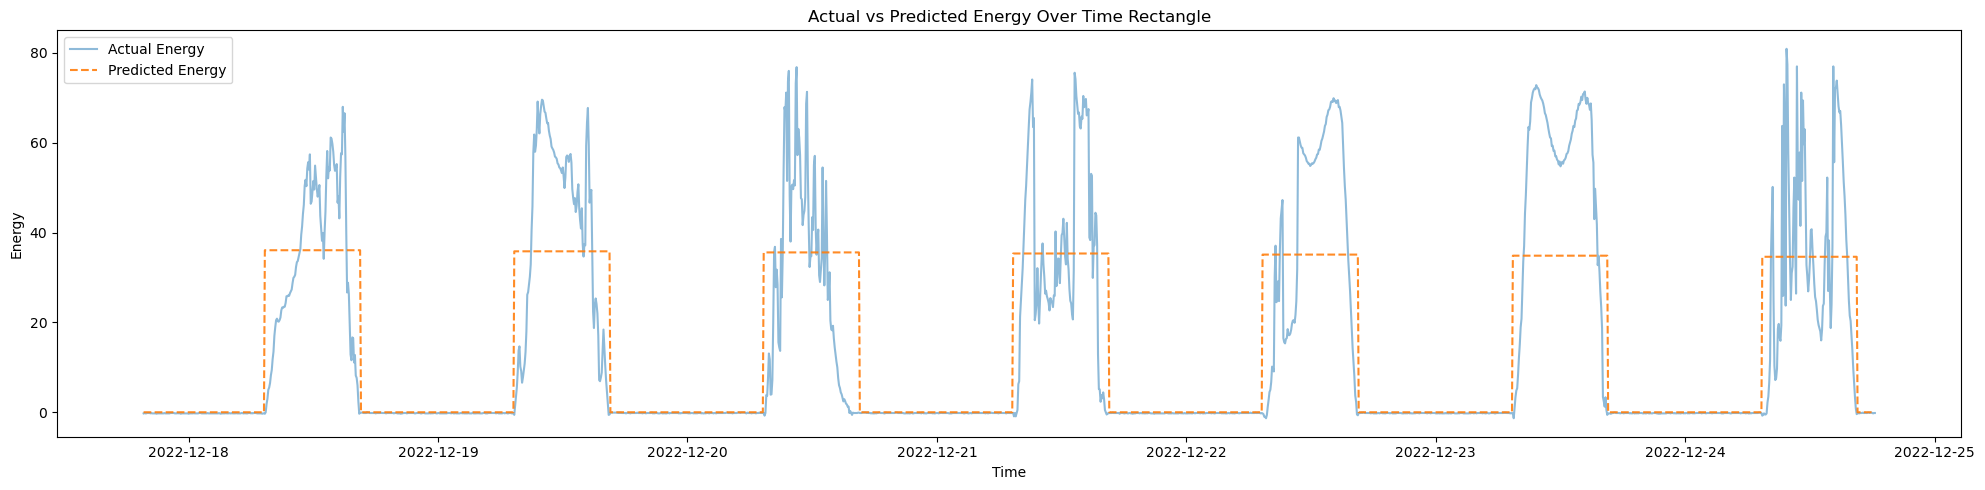

In [608]:
model_1.fit(X1,y1)
y1_pred = model_1.predict(X1)
y1_pred = np.clip(y1_pred,0,80)

plt.figure(figsize=(20, 5))
plt.plot(SolarData.index[-4000:-2000], y1[-4000:-2000], label='Actual Energy', alpha=0.5)
plt.plot(SolarData.index[-4000:-2000], y1_pred[-4000:-2000], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Rectangle")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [630]:
tscv = TimeSeriesSplit(n_splits = 5)

model_2 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('sin',FunctionTransformer(np.sin),['Day']),('cos',FunctionTransformer(np.cos),['Solar Zenith Angle'])],remainder='passthrough')),
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('scaling', StandardScaler()),
    ('regression', LinearRegression(n_jobs=-1))
])

X2 = SolarDataPos[['Day','Solar Zenith Angle','Relative Humidity','Cloud Type']]
y2 = SolarDataPos['Energy']

rmse_scores2 = cross_val_score(model_2, X2, y2, cv=tscv, scoring='neg_root_mean_squared_error')

print("RMSE scores:", -rmse_scores2)
print("Average RMSE:", -rmse_scores2.mean())

RMSE scores: [28.99356172 25.90796284 24.54541454 22.71200474 19.59574657]
Average RMSE: 24.350938082063657


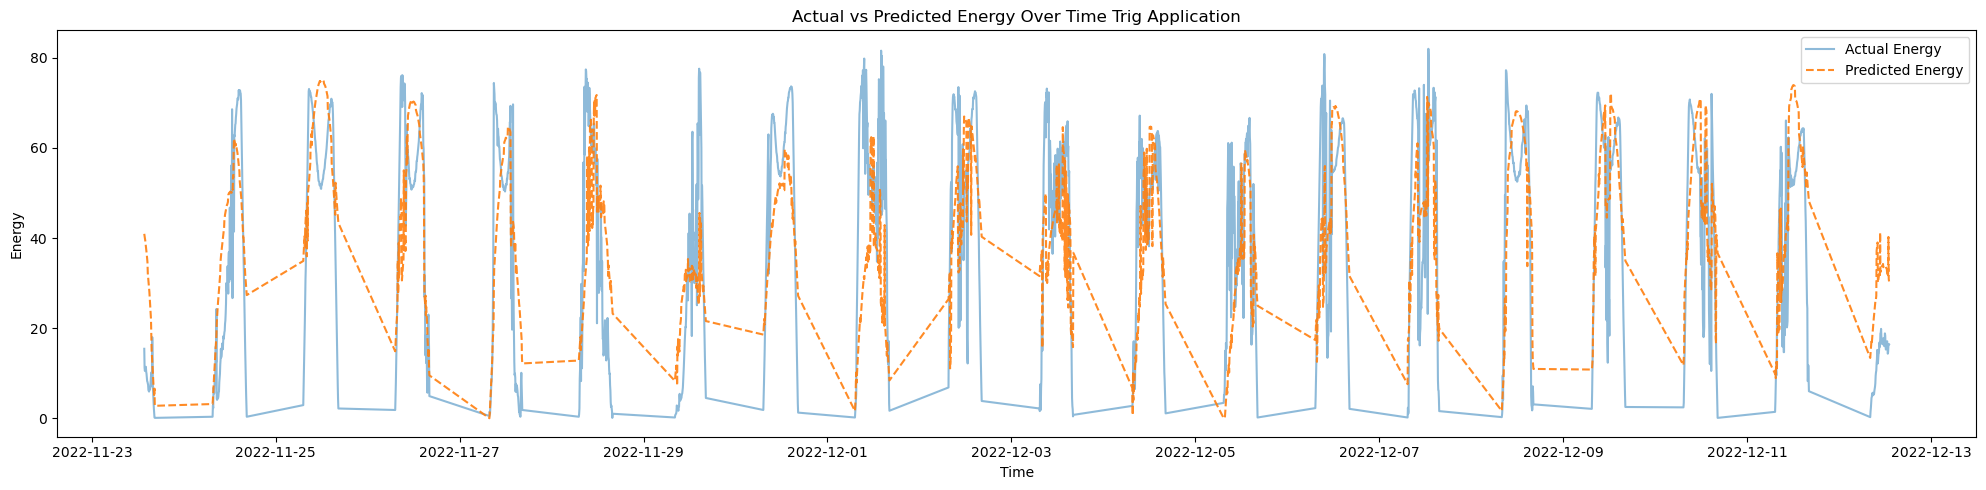

In [631]:
model_2.fit(X2,y2)
y2_pred = model_2.predict(X2)
y2_pred = np.clip(y2_pred,0,80)

plt.figure(figsize=(20, 5))
plt.plot(SolarDataPos.index[-4000:-2000], y2[-4000:-2000], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataPos.index[-4000:-2000], y2_pred[-4000:-2000], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Trig Application")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [611]:
model_3 = Pipeline(steps=[
    ('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('scaling', StandardScaler()),
    ('regression', LinearRegression(n_jobs=-1))
])

X3 = SolarDataPos[['Day','Solar Zenith Angle','Relative Humidity','Cloud Type']]
y3 = SolarDataPos['Energy']

rmse_scores3 = cross_val_score(model_3, X3, y3, cv=tscv, scoring='neg_root_mean_squared_error')

print("RMSE scores:", -rmse_scores3)
print("Average RMSE:", -rmse_scores3.mean())

RMSE scores: [18.31215196 16.89082678 16.10537279 12.05670489 17.32114011 15.97331113
 21.6496736  18.53580841 18.35129534 18.58132075]
Average RMSE: 17.37776057634566


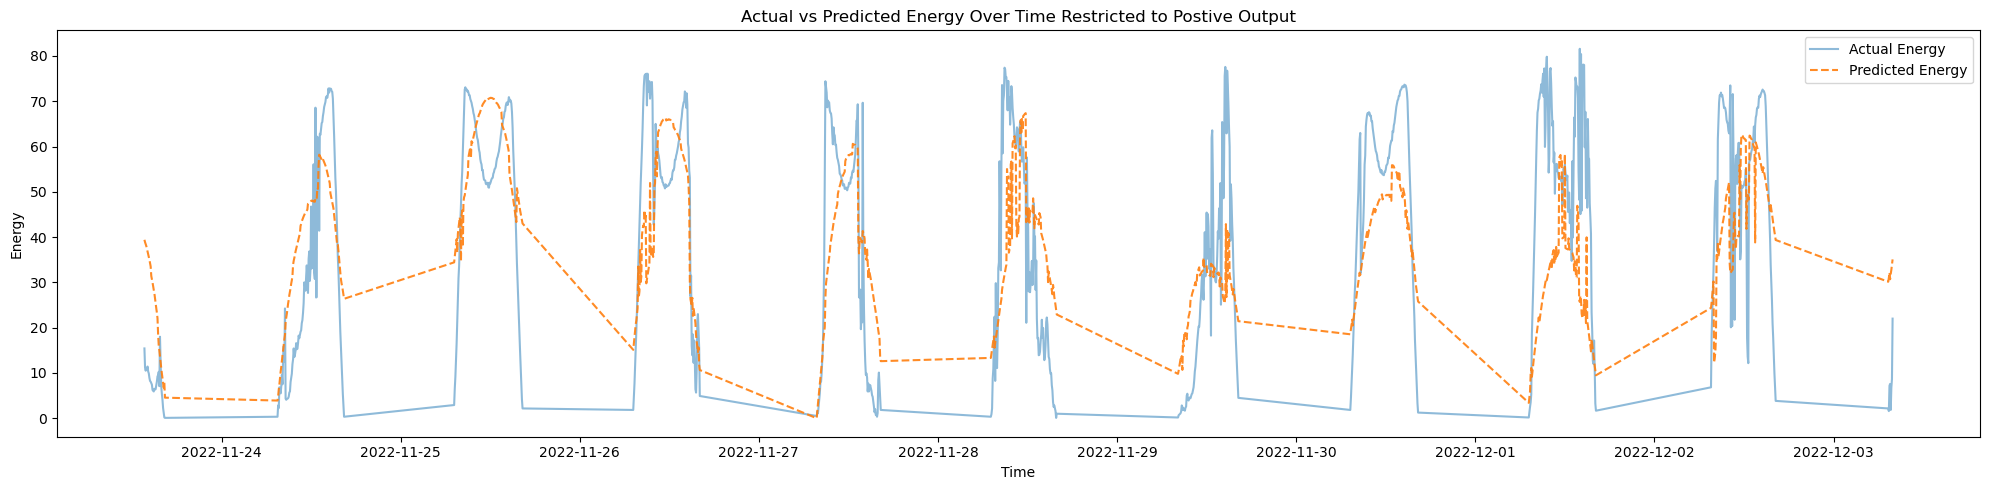

In [612]:
model_3.fit(X3,y3)
y3_pred = model_3.predict(X3)
y3_pred = np.clip(y3_pred,0,80)

plt.figure(figsize=(20, 5))
plt.plot(SolarDataPos.index[-4000:-3000], y3[-4000:-3000], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataPos.index[-4000:-3000], y3_pred[-4000:-3000], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time Restricted to Postive Output")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

In [628]:
tscv = TimeSeriesSplit(n_splits = 5)

def sng_cos(x):
    return np.sign(np.cos(x))

model_5 = Pipeline(steps=[
    ('feature_change', ColumnTransformer(transformers=[('sin',FunctionTransformer(np.sin),['Day'])],remainder='passthrough')),
    #('poly',PolynomialFeatures(degree=2,interaction_only=True)),
    ('scaling', StandardScaler()),
    ('regression', LinearRegression(n_jobs=-1))
])
X5 = SolarDataPos[['Solar Zenith Angle','Day','Relative Humidity','Cloud Type','Ambient Temperature']]
y5 = SolarDataPos['Energy']

rmse_scores5 = cross_val_score(model_5, X5, y5, cv=tscv, scoring='neg_root_mean_squared_error')

print("RMSE scores:", -rmse_scores5)
print("Average RMSE:", -rmse_scores5.mean())

RMSE scores: [28.50857292 27.01578104 23.9713401  22.45061241 19.63712759]
Average RMSE: 24.316686812675137


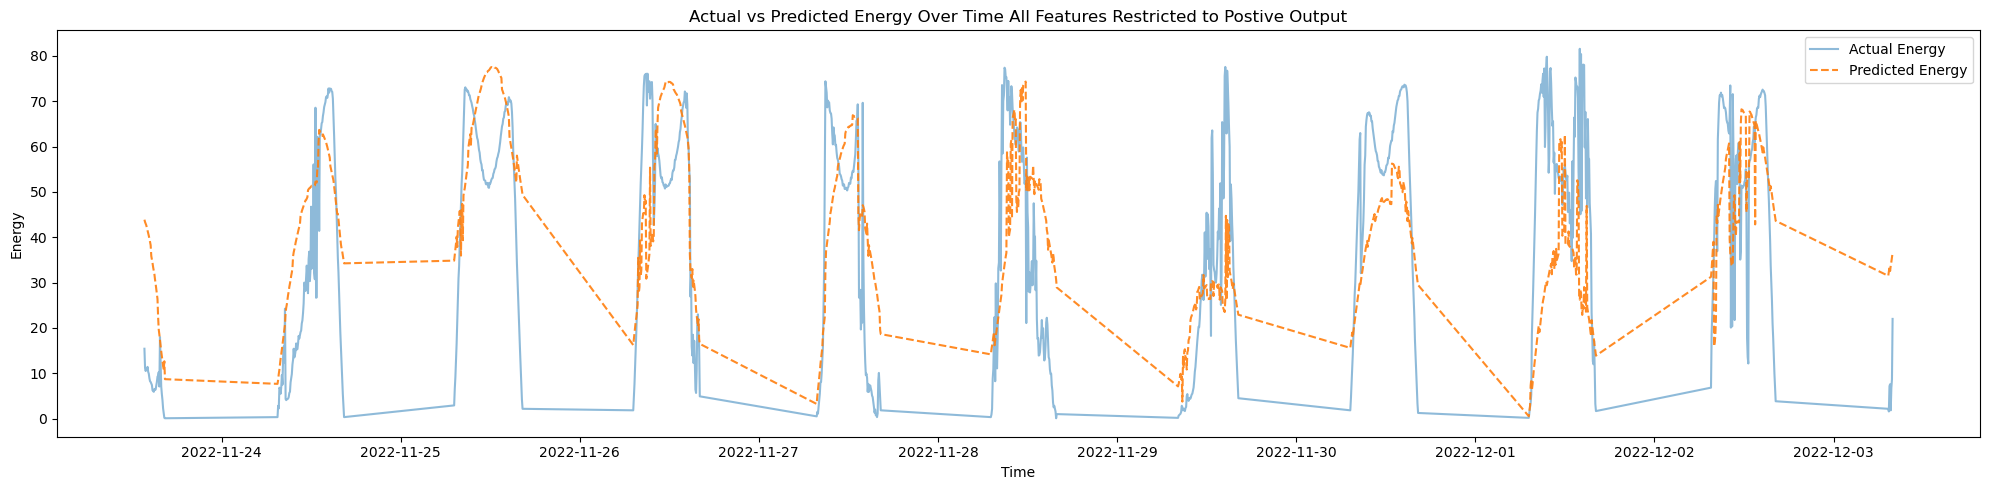

In [629]:
model_5.fit(X5,y5)
y5_pred = model_5.predict(X5)
y5_pred = np.clip(y5_pred,0,80)

plt.figure(figsize=(20, 5))
plt.plot(SolarDataPos.index[-4000:-3000], y5[-4000:-3000], label='Actual Energy', alpha=0.5)
plt.plot(SolarDataPos.index[-4000:-3000], y5_pred[-4000:-3000], label='Predicted Energy', linestyle='--', alpha=0.9)
plt.title("Actual vs Predicted Energy Over Time All Features Restricted to Postive Output")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()